In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set(style="white")

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

from scipy.cluster.vq import kmeans, vq

from sklearn.cluster import KMeans

from collections import Counter

df = pd.read_csv('books.csv', error_bad_lines=False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


Basic informations:


Rows: 11123

Columns: 12




This is really inspiring dataset, questions which comes to my mind right now are:

* books with how much pages people like to read the best?
* which authors are the most popular ?

## 1. Data preprocessing

### 1.1 Basic inspections

In [ ]:
df.head()

bookID                                              title  \
0       1  Harry Potter and the Half-Blood Prince (Harry ...   
1       2  Harry Potter and the Order of the Phoenix (Har...   
2       4  Harry Potter and the Chamber of Secrets (Harry...   
3       5  Harry Potter and the Prisoner of Azkaban (Harr...   
4       8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                      authors  average_rating        isbn         isbn13  \
0  J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969   
1  J.K. Rowling/Mary GrandPré            4.49  0439358078  9780439358071   
2                J.K. Rowling            4.42  0439554896  9780439554893   
3  J.K. Rowling/Mary GrandPré            4.56  043965548X  9780439655484   
4  J.K. Rowling/Mary GrandPré            4.78  0439682584  9780439682589   

  language_code    num_pages  ratings_count  text_reviews_count  \
0           eng          652        2095690               27591   
1           eng          870        2153167               29221   
2           eng          352           6333                 244   
3           eng          435        2339585               36325   
4           eng         2690          41428                 164   

  publication_date        publisher  
0        9/16/2006  Scholastic Inc.  
1         9/1/2004  Scholastic Inc.  
2        11/1/2003       Scholastic  
3         5/1/2004  Scholastic Inc.  
4        9/13/2004       Scholastic

Columns:

* bookID
* isbn - unique number to identify the book, the International Standard Book Number.
* isbn13- A 13-digit ISBN to identify the book, instead of the standard 11-digit ISBN.

don't contain any useful informations so they should be droped

In [ ]:
columns_to_drop = ['bookID', 'isbn', 'isbn13']

df.drop(columns=columns_to_drop, inplace=True)

### 1.2 DataTypes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11123 non-null  object 
 1   authors             11123 non-null  object 
 2   average_rating      11123 non-null  float64
 3   language_code       11123 non-null  object 
 4     num_pages         11123 non-null  int64  
 5   ratings_count       11123 non-null  int64  
 6   text_reviews_count  11123 non-null  int64  
 7   publication_date    11123 non-null  object 
 8   publisher           11123 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 782.2+ KB


Publication date should be converted to datetime, I think that rest is OK.

In [ ]:
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')

In [ ]:
df['publication_date'].head()

0   2006-09-16
1   2004-09-01
2   2003-11-01
3   2004-05-01
4   2004-09-13
Name: publication_date, dtype: datetime64[ns]

### 1.3 NULL  and DUPLICATES

One of the most important and time consuming thing in every data analysis is handling with null values.

In [ ]:
df.isnull().sum()

title                 0
authors               0
average_rating        0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      2
publisher             0
dtype: int64

Only 2 null values in publication_date, let's see:

In [ ]:
df.loc[df['publication_date'].isnull()]

title  \
8177   In Pursuit of the Proper Sinner (Inspector Lyn...   
11094         Montaillou  village occitan de 1294 à 1324   

                                               authors  average_rating  \
8177                                 Elizabeth  George            4.10   
11094  Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie            3.96   

      language_code    num_pages  ratings_count  text_reviews_count  \
8177            eng          718          10608                 295   
11094           fre          640             15                   2   

      publication_date       publisher  
8177               NaT    Bantam Books  
11094              NaT  Folio histoire

in this case it is possible to enter blank values manually, so:

[In Pursuit of the Proper Sinner](https://www.goodreads.com/book/show/31373.In_Pursuit_of_the_Proper_Sinner) - August 1999

[Montaillou village occitan de 1294 à 1324](https://en.wikipedia.org/wiki/Montaillou_(book)) - month in this case is not provided but there's year - 1975. I'm going to set date 1st of January


In [ ]:
df.loc[8177, 'publication_date'] = pd.to_datetime('1999-08-01')
df.loc[11094, 'publication_date'] = pd.to_datetime('1975-01-01')

**Duplicates**

In [ ]:
df[df.duplicated()]

Empty DataFrame
Columns: [title, authors, average_rating, language_code,   num_pages, ratings_count, text_reviews_count, publication_date, publisher]
Index: []

Looks like theres no duplicates in this dataset, let's fall into EDA

## 2. EDA

### 2.1 DESCRIBE METHOD

In [ ]:
df.describe()

average_rating     num_pages  ratings_count  text_reviews_count
count    11123.000000  11123.000000   1.112300e+04        11123.000000
mean         3.934075    336.405556   1.794285e+04          542.048099
std          0.350485    241.152626   1.124992e+05         2576.619589
min          0.000000      0.000000   0.000000e+00            0.000000
25%          3.770000    192.000000   1.040000e+02            9.000000
50%          3.960000    299.000000   7.450000e+02           47.000000
75%          4.140000    416.000000   5.000500e+03          238.000000
max          5.000000   6576.000000   4.597666e+06        94265.000000

Let's see the distributions of numeric values:

In [ ]:
numeric_features = df.select_dtypes(include=[np.number])

In [ ]:
def plot_histogram(column_name):
    
    """this function takes the name of the column
    returns plotly histogram
    
    arguments: column_name: str"""
    
    fig = px.histogram(data_frame=df, x=column_name, 
                       color_discrete_sequence=['mintcream'], log_y = True,
                      nbins=30)

    
    fig.update_layout(font=dict(family='Lato', size=18, color='white'), 
                title=dict(text=f'<b>{column_name}<b>',
                        font=dict(size=30), x=.5), 
                paper_bgcolor= 'goldenrod', plot_bgcolor='goldenrod',
                xaxis=dict(title=column_name, showgrid=False),
                yaxis=dict(title=f'count', showgrid=False))
    
    fig.show()

In [ ]:
for feature in numeric_features:
    plot_histogram(feature)

From the charts above the following conclusions can be drawn:

* average_rating - mostly rates are between 2 and 5 but there's some outliers which have less
* num_pages - this distribution is **right skewed** - the biggest amount of books have 0 - 500 pages but there's one outlier which have even number between 6500 - 6999
* ratings_count - ratings count is also **right skewed** as well with visible outliers
* text_reviews_count - distribution is also **right skewed** with some visible outliers 

Next thing may be interesting is distribution of the books per year.

In [ ]:
df['year'] = df['publication_date'].dt.year

In [ ]:
plot_histogram('year')

At first glance we can see that number of books increasing from 1900 to 2000 with, then it stared to decreasing

Now let's look for the best books and writers


In [ ]:
def bar_plot(column_name, data_frame=df, tribe='value_counts', by=None, limit=3, **kwargs):
    
    """arguments:
    column_name:str name of column from pandas data drame
    data_frame:pandas data frame default df
    tribe:str value counts by default, change to 'sort'
    by:str works only if sort tribe chosed, takes name of the column
        you want to sort values by"
    limit:int limit of values displayed"""
    
    
    # if column is not str type or column not in columns of data frame
    if type(column_name) != str or column_name not in data_frame.columns:
        raise ValueError('Incorect column name or type')
        
    if type(limit) != int:
        raise ValueErroc(f'excepted int type, got {type(limit)}')
    
    
    # sorted data frame
    if tribe == 'sort' :
        # if column is not in data frame
        if not by or by not in data_frame.columns:
            raise ValueError('by paramter must be column from data frame!')
        data = data_frame.sort_values(by=by, ascending=False).head(limit)
        y = data[by].values
        x = data[column_name]
        title = by
    
    # value counts
    elif tribe == 'value_counts':
        data = data_frame[column_name].value_counts().head(limit)
        x=data.index
        y=data.values
        title = column_name
    
    
    fig = px.bar(x=x, 
                 y=y,
            color_discrete_sequence=['mintcream']
                )

    fig.update_layout(font=dict(family='Lato', size=18, color='white'), 
                  title=dict(text=f'<b>{title}<b>',
                           font=dict(size=30), x=.5), 
                  paper_bgcolor= 'goldenrod', plot_bgcolor='goldenrod',
                 xaxis=dict(title=f'', showgrid=False),
                 yaxis=dict(title=f'count', showgrid=False))
        
    fig.show()

**PUBLISHER**

In [ ]:
bar_plot('publisher', limit=10)

**AUTHORS**

In [ ]:
bar_plot('authors', limit=10)

**LANGUAGE**

In [ ]:
bar_plot('language_code')

In [ ]:
df.rename(columns={'  num_pages': 'num_pages'}, inplace=True)
bar_plot('title', tribe='sort', by='num_pages', limit=5)

**RATINGS COUNT**

In [ ]:
bar_plot('title', tribe='sort', by='ratings_count')

**CORRELATION**

In [ ]:
def correlation_heatmap(data_frame=df):
    """arguments: data_frame:pandas DataFrame
       returns: correlation heatmap"""
    
    #  setting the context
    sns.set(context='paper', font='moonspace')
    
    #  making correlation object and saving it into variable
    correlation = df.corr()
    
    #  creating heatmap figure object (paper) and ax object (the plot)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    #  generating color palettes
    cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
    
    #  draw the heatmap
    heatmap = sns.heatmap(correlation, vmax=1,vmin=-1,center=0, square=False, annot=True, cmap=cmap,
                         lw=2, cbar=False)
    
    return heatmap

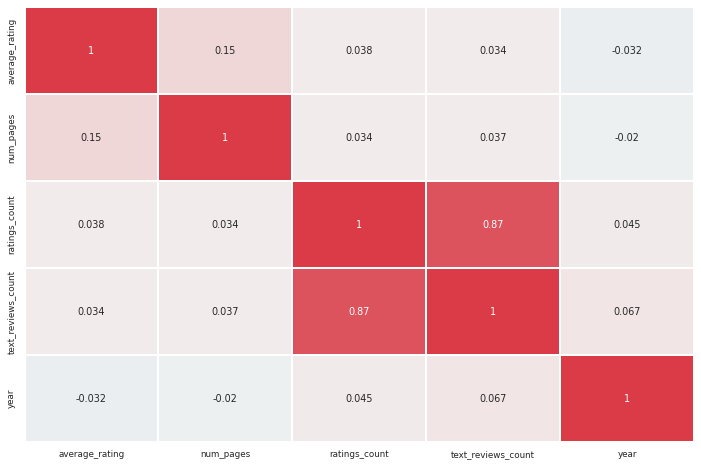

In [ ]:
correlation_heatmap();

There's weak correlation between number of pages and average rating and much bigger correlation between text_reviews_count and ratings_count

In [ ]:
def scatter_plot(x, y, data_frame=df):
    """this function takes x axis name and y axis name
    returns: plotly scatter plot"""
    
    fig = px.scatter(data_frame=data_frame, x=x, y=y, trendline='ols',
                    color_discrete_sequence=['mintcream'],
                    trendline_color_override="lime")
    
    fig.update_layout(font=dict(family='Lato', size=18, color='white'), 
                  title=dict(text=f'<b>{x} and {y}<b>',
                           font=dict(size=30), x=.5), 
                  paper_bgcolor= 'maroon', plot_bgcolor='maroon',
                 xaxis=dict(title=f'', showgrid=False),
                 yaxis=dict(title=f'count', showgrid=False))
    
    fig.show()

In [ ]:
scatter_plot(x='average_rating',y='num_pages')

In [ ]:
scatter_plot(x='text_reviews_count',y='ratings_count')

Before going futher to modeling the data and making clusters with Kmeans I think that good idea is to find outliers and drop them from train data

In [ ]:
train = df.copy()

In [ ]:
def detect_outliers(data_frame=train, n=2):
    """this funtion takes data frame and finds indexes of rows
    where it's more than n outliers
    arguments: data_frame: pandas DataFrame, default train
    n:int - takes the number n and 
    """
    
    numeric_columns = data_frame.select_dtypes(include=[np.number])
    outlires_indicies = []
    
    for column in numeric_columns:
        
        #  first quartile - 25 %
        Q1 = np.nanpercentile(data_frame[column], 25)
        
        #  second quartile - 75%
        Q2 = np.nanpercentile(data_frame[column], 75)
        
        #  calculating interquartile range
        IQR = Q2 - Q1
        
        # setting the bounds
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q2 + (1.5 * IQR)
        
        # indexes of the outliers
        outliers = data_frame[(data_frame[column] < lower_bound) | (data_frame[column] > upper_bound)].index
        
        #  extending the indicies to the list
        outlires_indicies.extend(outliers)
    
    #  this frequency table is useful to see occurences of outliers in rows
    freq_table = Counter(outlires_indicies)
    
    #  showing only indicies where theres more than n outliers
    return [index for index, occurences in freq_table.items() if occurences > n]

In [ ]:
outliers = detect_outliers()
train.drop(index=outliers, inplace=True)
f'outliers droped - {len(outliers)}'

'outliers droped - 106'

## 3. MODELING

KMeans clustering is type of the unsupervied learning which groups the data in unlabelled data.

In [ ]:
X = train[['average_rating', 'ratings_count']].values

In [ ]:
distorsions = []

for x in range (2, 31):
    k_means = KMeans(n_clusters=x)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)

In [ ]:
fig = px.line(x=range(2, 31), y=distorsions)

fig.update_layout(xaxis=dict(title='number of clusters'),
                 yaxis=dict(title='distorsion'),
                 title=dict(text='Elbow method', x=.5, 
                           font=dict(size=30)),
                 font=dict(family='Lato', size=16))

fig.add_vline(x=5, line_width=3, line_dash='dash', line_color='green')


fig.show()

The best number of clusters **is 5.**

In [ ]:
centroids, _ = kmeans(X, 5) # making 5 clusters

idx, _ = vq(X, centroids)

In [ ]:
train['clusters'] = idx

In [ ]:
fig = px.scatter(data_frame=train, x='average_rating', y='ratings_count', color='clusters',
          hover_data=['title'],height=700)

fig.update_coloraxes(showscale=False)

fig.update_layout(xaxis=dict(title='average rating'),
                 yaxis=dict(title='ratings_count'),
                 title=dict(text='Goodreads - clustering', x=.5, 
                           font=dict(size=30)),
                 font=dict(family='Lato', size=16))

From the plot above we can see because of one outlier - The Twilight all clustering is skewed. I'm going to left only the books with rating_count less than 4M.

In [ ]:
train = train.loc[train['ratings_count'] <= 3e6]

In [ ]:
fig = px.scatter(data_frame=train, x='average_rating', y='ratings_count', color='clusters',
          hover_data=['title'],height=700)

fig.update_coloraxes(showscale=False)


fig.update_layout(xaxis=dict(title='average rating'),
                 yaxis=dict(title='ratings_count'),
                 title=dict(text='Goodreads - clustering', x=.5, 
                           font=dict(size=30)),
                 font=dict(family='Lato', size=16))

From the plot above, we can see that the whole system can be classified to the clusters. 
As the count increases, the rating would end up near the cluster given above.
As the rating count seems to decrease, the average rating seems to become sparser, with higher volatility and less accuracy.